In [2]:
%matplotlib inline

from collections import defaultdict
from IPython import display
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch

# Data Acquisition

For this assignment, you must download the dataset from [here](http://ec2-52-41-153-66.us-west-2.compute.amazonaws.com:8000/data.zip) and extract it into `data/`. The dataset contains approximately 80K training images and 100 validation images, with multiple captions/tags for each image. For this assignment, we are only concerned with the tags and ignore the captions.

Ideally, unless you happen to have **much faster** internet than I do, you will want to download the data directly to your server: `wget http://ec2-52-41-153-66.us-west-2.compute.amazonaws.com:8000/data.zip`.

For question two on the assignment, the dataset also contains a JSON file that maps from the ImageNet labels to the category names. 

Following the data downloading and unzipping, the code below loads in the data into memory accordingly.

In [3]:
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 
def load_image(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor).unsqueeze(0)
    return image_var.cuda()

load_image('data/train2014/COCO_train2014_000000000009.jpg')

Variable containing:
( 0 , 0 ,.,.) = 
  0.0039  0.0078  0.0039  ...   0.0471  0.0471  0.0314
  0.0039  0.0039  0.0039  ...   0.0353  0.0353  0.0392
  0.0039  0.0039  0.0039  ...   0.0392  0.0392  0.0510
           ...             ⋱             ...          
  0.7137  0.7294  0.7137  ...   0.1686  0.1843  0.1686
  0.7059  0.6902  0.6863  ...   0.1765  0.1804  0.2039
  0.6784  0.6667  0.6706  ...   0.1922  0.2157  0.2275

( 0 , 1 ,.,.) = 
  0.1490  0.1490  0.1412  ...   0.0039  0.0039  0.0039
  0.1451  0.1412  0.1373  ...   0.0039  0.0039  0.0039
  0.1412  0.1373  0.1373  ...   0.0039  0.0039  0.0039
           ...             ⋱             ...          
  0.4392  0.4667  0.4549  ...   0.2588  0.2745  0.2863
  0.4353  0.4235  0.4196  ...   0.2745  0.2980  0.3137
  0.4118  0.4000  0.4000  ...   0.3020  0.3176  0.3020

( 0 , 2 ,.,.) = 
  0.5294  0.5294  0.5294  ...   0.1451  0.1412  0.1333
  0.5255  0.5333  0.5373  ...   0.1725  0.1451  0.1412
  0.5373  0.5490  0.5451  ...   0.2314  0.1843

In [12]:
# Load ImageNet label to category name mapping.
imagenet_categories = [value for key,value in sorted(json.load(open('data/imagenet_categories.json')).items(), key=lambda t: int(t[0]))]

# Load annotations file for the 100K training images.
mscoco_train = json.load(open('data/annotations/train2014.json'))
train_ids = [entry['id'] for entry in mscoco_train['images']]
train_id_to_file = {entry['id']: 'data/train2014/' + entry['file_name'] for entry in mscoco_train['images']}
category_to_name = {entry['id']: entry['name'] for entry in mscoco_train['categories']}
category_idx_to_name = [entry['name'] for entry in mscoco_train['categories']]
category_to_idx = {entry['id']: i for i,entry in enumerate(mscoco_train['categories'])}

# Load annotations file for the 100 validation images.
mscoco_val = json.load(open('data/annotations/val2014.json'))
val_ids = [entry['id'] for entry in mscoco_val['images']]
val_id_to_file = {entry['id']: 'data/val2014/' + entry['file_name'] for entry in mscoco_val['images']}

# We extract out all of the category labels for the images in the training set. We use a set to ignore 
# duplicate labels.
train_id_to_categories = defaultdict(set)
for entry in mscoco_train['annotations']:
    train_id_to_categories[entry['image_id']].add(entry['category_id'])

# We extract out all of the category labels for the images in the validation set. We use a set to ignore 
# duplicate labels.
val_id_to_categories = defaultdict(set)
for entry in mscoco_val['annotations']:
    val_id_to_categories[entry['image_id']].add(entry['category_id'])

Let us take a look at an image and its corresponding category labels. We consider the image with the id 391895 and the corresponding filename, `data/val2014/COCO_val2014_000000391895.jpg`. The image is shown below.

![image](data/val2014/COCO_val2014_000000391895.jpg)

The following code determines the category labels for this image.

In [6]:
for i,category in enumerate(val_id_to_categories[391895]):
    print("%d. %s" % (i, category_to_name[category]))

0. person
1. bicycle
2. motorcycle


# 1. Loading a Pre-trained Convolutional Neural Network (CNN)

We will work with the VGG-16 image classification CNN network first introduced in [Very Deep Convolutional Neural Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf) by K. Simonyan and A. Zisserman.

Fairly straightforwardly, we load the pre-trained VGG model and indicate to PyTorch that we are using the model for inference rather than training.

In [7]:
vgg_model = models.vgg16(pretrained=True).cuda()
vgg_model.eval()

# Let's see what the model looks like.
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

# 2. Making Predictions Using VGG-16

Given the pre-trained network, we must now write the code to make predictions on the 10 validation images via a forward pass through the network. Typically the final layer of VGG-16 is a softmax layer, however the pre-trained PyTorch model that we are using does not have softmax built into the final layer (instead opting to incorporate it into the loss function) and therefore we must **manually** apply softmax to the output of the function.

Image ID: 391895


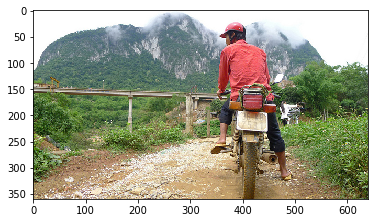

0. person
1. bicycle
2. motorcycle
assault rifle, assault gun - 0.15975740551948547
stretcher - 0.11209806054830551
rifle - 0.08013106137514114
military uniform - 0.05695948004722595
jeep, landrover - 0.04560714587569237


Image ID: 522418


C:\Users\belin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


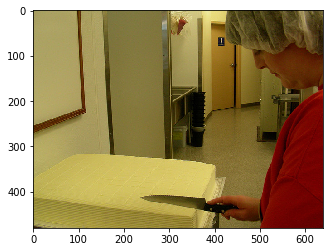

0. sink
1. person
2. cake
3. knife
mosquito net - 0.2567005157470703
toilet tissue, toilet paper, bathroom tissue - 0.08372808992862701
wardrobe, closet, press - 0.08117163181304932
washbasin, handbasin, washbowl, lavabo, wash-hand basin - 0.04646625742316246
medicine chest, medicine cabinet - 0.0376296266913414


Image ID: 184613


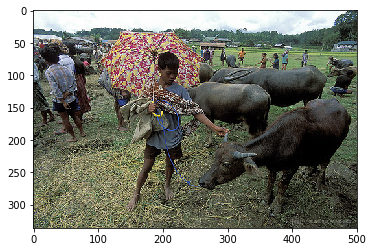

0. person
1. umbrella
2. cow
Arabian camel, dromedary, Camelus dromedarius - 0.1697528064250946
sandbar, sand bar - 0.08139925450086594
Italian greyhound - 0.07311606407165527
Weimaraner - 0.06620091944932938
swimming trunks, bathing trunks - 0.03160366043448448


Image ID: 318219


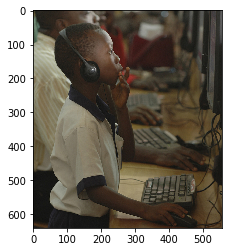

0. tv
1. person
2. mouse
3. keyboard
plastic bag - 0.12806940078735352
lab coat, laboratory coat - 0.09797225147485733
toilet tissue, toilet paper, bathroom tissue - 0.06251281499862671
bonnet, poke bonnet - 0.05905646085739136
gasmask, respirator, gas helmet - 0.057441599667072296


Image ID: 554625


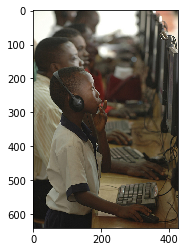

0. tv
1. person
2. mouse
3. keyboard
plastic bag - 0.07708378881216049
groom, bridegroom - 0.07356971502304077
gasmask, respirator, gas helmet - 0.07237771898508072
toilet tissue, toilet paper, bathroom tissue - 0.06662335991859436
mosquito net - 0.05071510002017021


Image ID: 397133


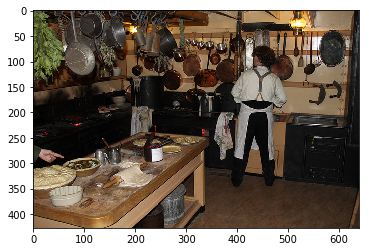

0. person
1. dining table
2. bottle
3. oven
4. cup
5. knife
6. spoon
7. bowl
8. sink
9. broccoli
10. carrot
dining table, board - 0.3610766530036926
grand piano, grand - 0.19368426501750946
mosquito net - 0.10433466732501984
restaurant, eating house, eating place, eatery - 0.033410023897886276
desk - 0.019991032779216766


Image ID: 574769


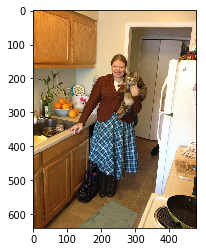

0. potted plant
1. person
2. bottle
3. oven
4. cat
5. refrigerator
6. spoon
7. bowl
8. clock
9. sink
10. orange
11. handbag
bath towel - 0.08988553285598755
dishwasher, dish washer, dishwashing machine - 0.08958844095468521
shower cap - 0.05552070215344429
bassinet - 0.047801241278648376
hand blower, blow dryer, blow drier, hair dryer, hair drier - 0.04668154567480087


Image ID: 60623


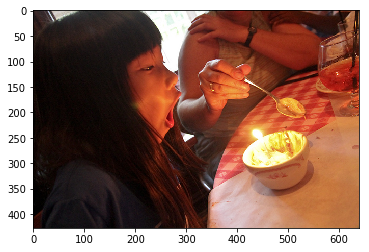

0. person
1. dining table
2. wine glass
3. spoon
4. bowl
Petri dish - 0.20456364750862122
bubble - 0.07023517787456512
groom, bridegroom - 0.03852198272943497
tub, vat - 0.035935863852500916
candle, taper, wax light - 0.0335400216281414


Image ID: 309022


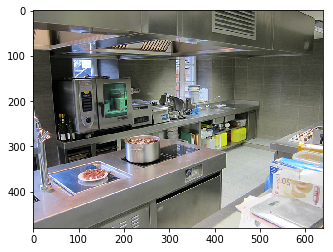

0. sink
1. bowl
2. bottle
3. oven
photocopier - 0.2724733352661133
refrigerator, icebox - 0.19897708296775818
medicine chest, medicine cabinet - 0.08541077375411987
microwave, microwave oven - 0.0789535716176033
dishwasher, dish washer, dishwashing machine - 0.0678602084517479


Image ID: 5802


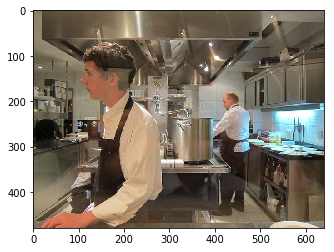

0. person
1. bottle
2. cup
3. knife
4. bowl
5. backpack
lab coat, laboratory coat - 0.48053592443466187
mosquito net - 0.20499716699123383
hoopskirt, crinoline - 0.027210207656025887
pajama, pyjama, pj's, jammies - 0.024719005450606346
beaker - 0.023093335330486298




In [10]:
softmax = nn.Softmax()
for image_id in val_ids[:10]:
    # Display the image.
    # -- Your code goes here --
    print("Image ID: {}".format(image_id))
    filename = val_id_to_file[image_id]
    image = Image.open(filename)
    plt.imshow(image)
    plt.show()

    # Print all of the category labels for this image.
    # -- Your code goes here --
    for cat_i,category in enumerate(val_id_to_categories[image_id]):
        print("%d. %s" % (cat_i, category_to_name[category]))
  
    # Load/preprocess the image.
    img = load_image(val_id_to_file[image_id])

    # Run the image through the model and softmax.
    label_likelihoods = softmax(vgg_model(img)).squeeze()

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)

    # Iterate and print out the predictions.
    # -- Your code goes here --
    probs_indices = zip(probs.cpu().data.numpy(), indices.cpu().data.numpy())
    for prob, index in probs_indices:
        print("{} - {}".format(imagenet_categories[index], prob))

    print("\n")

# 3. Computing Generic Visual Features using CNN

Since, rather than the output of VGG, we want a fixed sized vector representation of each image, we remove the last linear layer. The implementation of the forward function for VGG is shown below:

```
x = self.features(x)
x = x.view(x.size(0), -1)
x = self.classifier(x)
```
We aim to preserve everything but the final component of the classifier, meaning we must define an alternative equivalent to `self.classifier`.

In [13]:
# Remove the final layer of the classifier, and indicate to PyTorch that the model is being used for inference
# rather than training (most importantly, this disables dropout).
    
# -- Your code goes here --
"""
Sequential(
  (0): Linear(in_features=25088, out_features=4096)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000)
)
"""
# Need to keep layers 1 to 5
vgg_model.classifier = nn.Sequential(*(vgg_model.classifier[i] for i in range(6)))
# Put in eval mode disables dropout: https://github.com/pytorch/pytorch/issues/1207
vgg_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [27]:
# First we vectorize all of the features of training images and write the results to a file.

# -- Your code goes here --
training_vectors = np.zeros((len(train_ids), 4096))
for index, img_id in enumerate(train_ids):
    if index % 10000 == 0:
        print("Index {}".format(index))

    img = load_image(train_id_to_file[img_id])
    training_vectors[index] = vgg_model(img).cpu().data.numpy()

print(training_vectors.shape)
np.save(open('outputs/training_vectors', 'wb+'), training_vectors)

Index 0
Index 10000
Index 20000
Index 30000
Index 40000
Index 50000
Index 60000
Index 70000
Index 80000
(82783, 4096)


In [26]:
# Next we vectorize all of the features of validation images and write the results to a file.
    
# -- Your code goes here --
validation_vectors = np.zeros((len(val_ids), 4096))
for index, img_id in enumerate(val_ids):
    if index % 10000 == 0:
        print("Index {}".format(index))

    img = load_image(val_id_to_file[img_id])
    validation_vectors[index] = vgg_model(img).cpu().data.numpy()

print(validation_vectors.shape)
np.save(open('outputs/validation_vectors', 'wb+'), validation_vectors)

Index 0
(100, 4096)


# 4. Visual Similarity

We now use the generated vectors, to find the closest training image for each validation image. This can easily be done by finding the training vector that minimizes the Euclidean distance for every validation image. We repeat this exercise for the first 10 images in the validation set.

In [21]:
# Load back the saved vectors
training_vectors = np.load('outputs/training_vectors')
print(training_vectors.shape)
validation_vectors = np.load('outputs/validation_vectors')
print(validation_vectors.shape)

(82783, 4096)
(100, 4096)


Val. image: 391895, Train image 449158, Distance 624.9132735236947


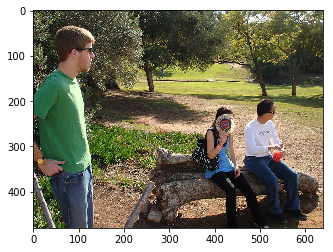

Val. image: 522418, Train image 518189, Distance 362.54469580428577


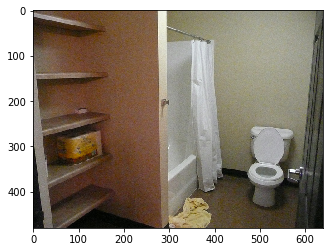

Val. image: 184613, Train image 85035, Distance 615.6073740159488


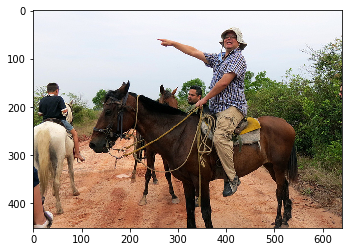

Val. image: 318219, Train image 14769, Distance 428.3332975637537


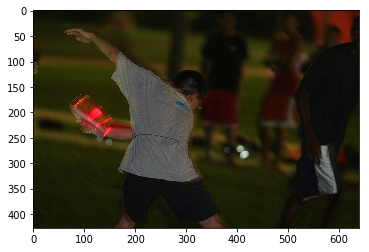

Val. image: 554625, Train image 388830, Distance 395.06273938008525


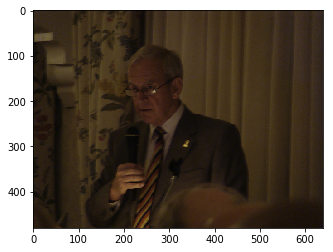

Val. image: 397133, Train image 10369, Distance 603.3744976973742


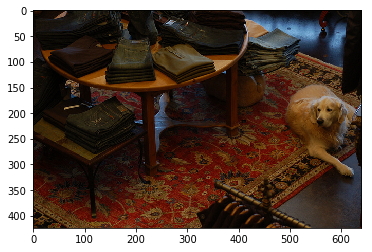

Val. image: 574769, Train image 313285, Distance 396.3196375895536


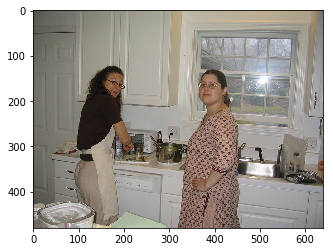

Val. image: 60623, Train image 546311, Distance 512.5681089081975


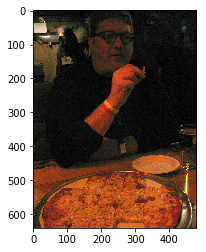

Val. image: 309022, Train image 578915, Distance 506.7069143715148


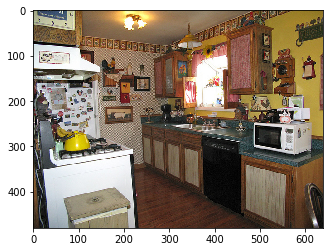

Val. image: 5802, Train image 415232, Distance 464.8927881330262


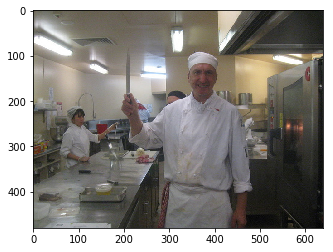

In [25]:
# -- Your code goes here --
for index, img_id in enumerate(val_ids[:10]):
    img_vector = validation_vectors[index]
    distance_vector = np.sum(np.square(img_vector-training_vectors), axis=1)
    closest_index = np.argmin(distance_vector)
    print('Val. image: {}, Train image {}, Distance {}'.format(img_id, train_ids[closest_index], distance_vector[closest_index]))
    filename = train_id_to_file[train_ids[closest_index]]
    image = Image.open(filename)
    plt.imshow(image)
    plt.show()
    

# 5. Training a Multi-Label Classification Network

We now build a two layer classification network, which takes 4096-dimensional vectors as input and outputs the probabilities of the 80 categories present in MSCOCO. 

For this purpose, we utilize two layers (both containing sigmoid activation functions) with the hidden dimension set to 512. 

In [22]:
# First we construct a class for the model
# -- Your code goes here --


[57870,
 384029,
 222016,
 520950,
 69675,
 547471,
 122688,
 392136,
 398494,
 90570,
 504616,
 161919,
 457732,
 44404,
 4428,
 170558,
 405613,
 283524,
 37015,
 71631,
 491269,
 365363,
 64460,
 581674,
 470072,
 344806,
 84427,
 317237,
 409382,
 570608,
 469605,
 356702,
 405207,
 472925,
 214704,
 279108,
 438422,
 257350,
 393493,
 62426,
 19380,
 485894,
 446014,
 530683,
 292835,
 262845,
 299411,
 42493,
 239811,
 2024,
 95133,
 287541,
 441488,
 179620,
 70000,
 536587,
 543877,
 420721,
 540162,
 218956,
 318574,
 172899,
 352884,
 394326,
 535786,
 357684,
 576757,
 165499,
 181104,
 55627,
 241364,
 209967,
 153674,
 354444,
 98760,
 311914,
 467311,
 236772,
 49183,
 426038,
 309322,
 318189,
 343322,
 36633,
 213546,
 378710,
 189993,
 551125,
 77806,
 546451,
 444546,
 147016,
 497616,
 520208,
 199628,
 280980,
 167613,
 142088,
 301778,
 454325,
 289019,
 246804,
 62604,
 388911,
 412535,
 62279,
 496939,
 66514,
 93785,
 486320,
 217306,
 287927,
 269829,
 353139,


In [ ]:
# The output data is prepared by representing each output as a binary vector of categories
# -- Your code goes here --

def train(model, learning_rate=0.001, batch_size=100, epochs=5):
    """
    Training function which takes as input a model, a learning rate and a batch size.
  
    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
    # -- Your code goes here --

# Finally train the model
train(model)

In [ ]:
# Now repeat step two using the two layer classifier.
# -- Your code goes here --

# 6. End-to-End Model Fine-tuning

Instead of training *only* the final two layers, we now create an end-to-end model and train the entire thing. 

In [ ]:
# First we construct a class for the model
# -- Your code goes here --

In [ ]:
# The output data is prepared by representing each output as a binary vector of categories
# -- Your code goes here --

def train(model, learning_rate=0.001, batch_size=50, epochs=2):
    """
    Training function which takes as input a model, a learning rate and a batch size.
  
    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
    # -- Your code goes here --
    
# Finally train the model
train(model)

In [ ]:
# Now repeat step two using the end-to-end classifier.
# -- Your code goes here --

# 7. Hyper-parameter Tuning

Now we do a grid search over the learning rate and batch size.

In [ ]:
# -- Your code goes here --